The third edition of *Think Stats* is available now from [Bookshop.org](https://bookshop.org/a/98697/9781098190255) and [Amazon](https://amzn.to/42lmxwu) (those are affiliate links). If you are enjoying the free, online version, consider [buying me a coffee](https://buymeacoffee.com/allendowney).

# Relationships between variables

So far we have only looked at one variable at a time.
In this chapter we start looking at relationships between variables.
Two variables are related if knowing one gives you information about the other.
For example, height and weight are related -- people who are taller tend to be heavier.
Of course, it is not a perfect relationship: there are short heavy people and tall light ones.
But if you are trying to guess someone's weight, you will be more accurate if you know their height than if you don't.

This chapter presents several ways to visualize relationships between variables, and one way to quantify the strength of a relationship, correlation.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap07.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

In [2]:
try:
    import empiricaldist
except ImportError:
    %pip install empiricaldist

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## Scatter Plots

If you meet someone who is unusually good at math, do you expect their verbal skills to be better or worse than average?
On one hand, you might imagine that people specialize in one area or the other, so someone who excels at one might be less good at the other.
On the other hand, you might expect someone who is generally smart to be above average in both areas.
Let's find out which it is.

We'll use data from the National Longitudinal Survey of Youth 1997 (NLSY97), which "follows the lives of a sample of 8,984 American youth born between 1980-84".
The public data set includes the participants' scores on several standardized tests, including the tests most often used in college admissions, the SAT and ACT.
Because test-takers get separate scores for the math and verbal sections, we can use this data to explore the relationship between mathematical and verbal ability.

I used the NLS Investigator to create an excerpt that contains the variables I'll use for this analysis.
With their permission, I can redistribute this excerpt.
Instructions for downloading the data are in the notebook for this chapter.

- 전문화 가설 — 사람들은 특정 영역에 특화되므로, 한 쪽이 뛰어나면 다른 쪽은 떨어질 수 있다.
- 일반 지능 가설 — 전반적으로 지능이 높은 사람은 두 영역 모두 평균 이상일 가능성이 높다.

In [4]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/nlsy97-extract.csv.gz")

Downloaded nlsy97-extract.csv.gz


We can use `read_csv` to read the data and `replace` to replace the special codes for missing data with `np.nan`.

In [5]:
missing_codes = [-1, -2, -3, -4, -5]
nlsy = pd.read_csv("nlsy97-extract.csv.gz").replace(missing_codes, np.nan)
nlsy.shape

(8984, 34)

In [6]:
nlsy.head()

,R0000100,R0490200,R0536300,R0536401,R0536402,R1235800,R1318200,R1482600,R3961900,R3989200,...,R9872200,R9872300,R9872400,S1552700,U0008900,U1845500,U3444000,U4949700,Z9083800,Z9083900
0,1,NaN,2,9,1981,1,NaN,4,NaN,NaN,...,293.0,250.0,333.0,NaN,120000.0,NaN,NaN,NaN,16.0,4.0
1,2,NaN,1,7,1982,1,145.0,2,NaN,NaN,...,114.0,230.0,143.0,NaN,98928.0,116000.0,188857.0,180000.0,14.0,2.0
2,3,NaN,2,9,1983,1,82.0,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75000.0,16.0,4.0
3,4,NaN,2,2,1981,1,NaN,2,NaN,NaN,...,195.0,230.0,216.0,NaN,85000.0,45000.0,NaN,NaN,13.0,2.0
4,5,NaN,1,10,1982,1,NaN,2,NaN,NaN,...,293.0,230.0,231.0,NaN,210000.0,212000.0,NaN,240000.0,12.0,2.0


The `DataFrame` contains one row for each of the 8984 participants in the survey and one column for each of the 34 variables I selected.
The column names don't mean much by themselves, so let's replace the ones we'll use with more interpretable names.

In [7]:
nlsy["sat_verbal"] = nlsy["R9793800"]
nlsy["sat_math"] = nlsy["R9793900"]

Both columns contain a few values less than 200, which is not possible because 200 is the lowest score, so we'll replace them with `np.nan`.

In [8]:
columns = ["sat_verbal", "sat_math"]

for column in columns:
    invalid = nlsy[column] < 200
    nlsy.loc[invalid, column] = np.nan

Next we'll use `dropna` to select only rows where both scores are valid.

In [9]:
nlsy_valid = nlsy.dropna(subset=columns).copy()
nlsy_valid.shape

(1398, 36)

SAT scores are standardized so the mean is 500 and the standard deviation is 100.
In the NLSY sample, the means and standard deviations are close to these values.

In [10]:
sat_verbal = nlsy_valid["sat_verbal"]
sat_verbal.mean(), sat_verbal.std()

(501.80972818311875, 108.36562024213643)

In [11]:
sat_math = nlsy_valid["sat_math"]
sat_math.mean(), sat_math.std()

(503.0829756795422, 109.8329973731453)

Now, to see whether there is a relationship between these variables, let's look at a **scatter plot**.

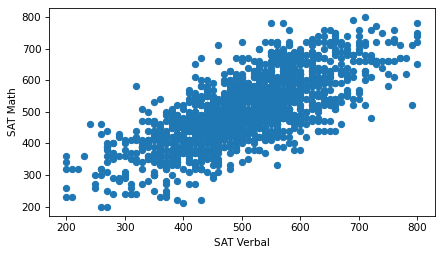

In [12]:
plt.scatter(sat_verbal, sat_math)

decorate(xlabel="SAT Verbal", ylabel="SAT Math")

Using the default options of the `scatter` function, we can see the general shape of the relationship.
People who do well on one section of the test tend to do better on the other, too.

However, this version of the figure is **overplotted**, which means there are a lot of overlapping points, which can create a misleading impression of the relationship.
The center, where the density of points is highest, is not as dark as it should be -- by comparison, the extreme values are darker than they should be.
Overplotting tends to give too much visual weight to outliers.

We can improve the plot by reducing the size of the markers so they overlap less.

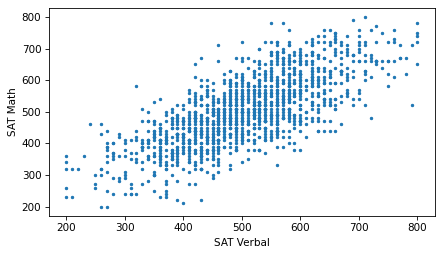

In [13]:
plt.scatter(sat_verbal, sat_math, s=5)

decorate(xlabel="SAT Verbal", ylabel="SAT Math")

Now we can see that the markers are aligned in rows and columns, because scores are rounded off to the nearest multiple of 10.
Some information is lost in the process.

We can't get that information back, but we can minimize the effect on the scatter plot by **jittering** the data, which means adding random noise to reverse the effect of rounding off.
The following function takes a sequence and jitters it by adding random values from a normal distribution with mean 0 and the given standard deviation.
The result is a NumPy array.

In [14]:
def jitter(seq, std=1):
    n = len(seq)
    return np.random.normal(0, std, n) + seq

If we jitter the scores with a standard deviation of 3, the rows and columns are no longer visible in the scatter plot.

In [15]:
sat_verbal_jittered = jitter(sat_verbal, 3)
sat_math_jittered = jitter(sat_math, 3)

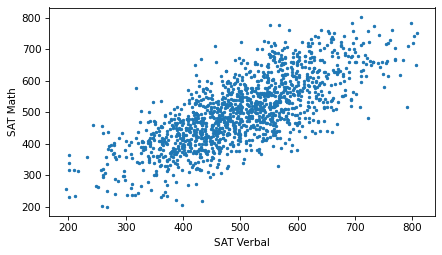

In [16]:
plt.scatter(sat_verbal_jittered, sat_math_jittered, s=5)

decorate(xlabel="SAT Verbal", ylabel="SAT Math")

Jittering reduces the visual effect of rounding and makes the shape of the relationship clearer.
But in general you should only jitter data for purposes of visualization and avoid using jittered data for analysis.

In this example, even after adjusting the marker size and jittering the data, there is still some overplotting.
So let's try one more thing: we can use the `alpha` keyword to make the markers partly transparent.

- Jittering : 데이터 점들의 위치에 작은 무작위값을 더해서 겹침(overplotting)을 줄이는 방법.
시험 점수 같은 데이터는 정수 값이어서 동일한 좌표에 많은 점이 몰림. 약간 흩뿌려주면 데이터의 전반적인 형태를 더 잘 볼 수 있음.
- 투명도(alpha) 조절

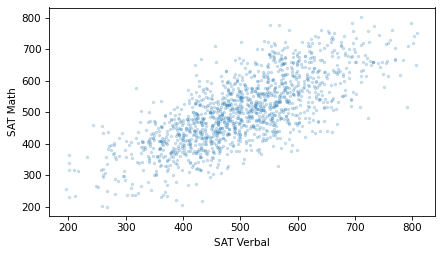

In [17]:
plt.scatter(sat_verbal_jittered, sat_math_jittered, s=5, alpha=0.2)

decorate(xlabel="SAT Verbal", ylabel="SAT Math")

With transparency, overlapping data points look darker, so darkness is proportional to density.

Although scatter plots are a simple and widely-used visualization, they can be hard to get right.
In general, it takes some trial and error to adjust marker sizes, transparency, and jittering to find the best visual representation of the relationship between variables.

## Decile Plots

Scatter plots provide a general impression of the relationship between variables, but there are other visualizations that provide more insight into the nature of the relationship.
One of them is a **decile plot**.

To generate a decile plot, we'll sort the respondents by verbal score and divide them into 10 groups, called **deciles**.
We can use the `qcut` method to compute the deciles.

### Decile Plot
- 데이터 분석에서 사용되며, 특히 고객 분류(Segmentation)나 마케팅 캠페인의 효과를 분석할때 사용
- 상위 고객 집중도, 고객 분포

- 1 : 가장 높은 상위 10% 고객 그룹

In [18]:
deciles = pd.qcut(nlsy_valid["sat_verbal"], 10, labels=False) + 1
deciles.value_counts().sort_index()

sat_verbal
1     142
2     150
3     139
4     140
5     159
6     130
7     148
8     121
9     138
10    131
Name: count, dtype: int64

The number of respondents in each decile is roughly equal.

Now we can use the `groupby` method to divide the `DataFrame` into groups by `decile`.

In [19]:
df_groupby = nlsy_valid.groupby(deciles)
df_groupby

The result is a `DataFrameGroupBy` object that represents the groups.
We can select the `sat_math` column from it.

In [20]:
series_groupby = df_groupby["sat_math"]
series_groupby

The result is a `SeriesGroupBy` object that represents the math scores in each decile.
We can use the `quantile` function to compute the 10th, 50th, and 90th percentiles in each group.

In [21]:
low = series_groupby.quantile(0.1)
median = series_groupby.quantile(0.5)
high = series_groupby.quantile(0.9)

A decile plot shows these percentiles for each decile group.
In the following figure, the line shows the median and the shaded region shows the area between the 10th and 90th percentiles.

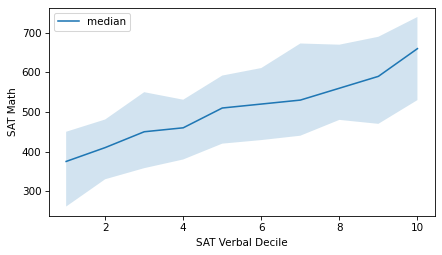

In [22]:
xs = median.index
plt.fill_between(xs, low, high, alpha=0.2)
plt.plot(xs, median, label="median")

decorate(xlabel="SAT Verbal Decile", ylabel="SAT Math")

- 순위에 기반하여 그룹간의 관계

- 각 점수의 중앙값을 연결한 선

As an alternative, we can compute the median verbal score in each group and plot those values on the x-axis, rather than the decile numbers.

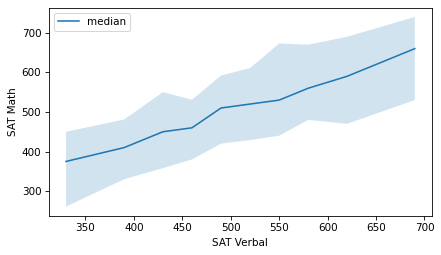

In [23]:
xs = df_groupby["sat_verbal"].median()

plt.fill_between(xs, low, high, alpha=0.2)
plt.plot(xs, median, color="C0", label="median")

decorate(xlabel="SAT Verbal", ylabel="SAT Math")

- 점수에 기반하여 관계

- 사실상 산점도?

It looks like the relationship between these variables is linear -- that is, each increase in the median verbal scores corresponds to a roughly equal increase in median math scores.

More generally, we could divide the respondents into any number of groups, not necessarily 10, and we could compute other summary statistics in each group, not just these percentiles.

## Correlation

When the NLSY participants were in 9th grade, many of them took the mathematics section of the Peabody Individual Achievement Test (PIAT).
Let's give the column that contains the results a more interpretable name.

In [24]:
nlsy["piat_math"] = nlsy["R1318200"]
nlsy["piat_math"].describe()

count    6044.000000
mean       93.903706
std        14.631148
min        55.000000
25%        84.000000
50%        92.000000
75%       103.000000
max       145.000000
Name: piat_math, dtype: float64

Here's what the distribution of scores looks like.

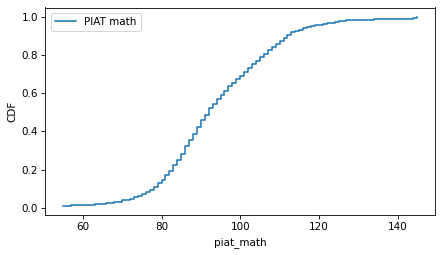

In [25]:
from empiricaldist import Cdf

cdf_piat_math = Cdf.from_seq(nlsy["piat_math"], name="PIAT math")
cdf_piat_math.step()
decorate(ylabel="CDF")

Students who do well on the PIAT in 9th grade are likely to do well on the SAT math section in 12th grade.
For the NLSY participants who took both tests, the following scatter plot shows the relationship between their scores.
It uses the `scatter` function in `thinkstats`, which adjusts the marker size and transparency, and optionally jitters the data.

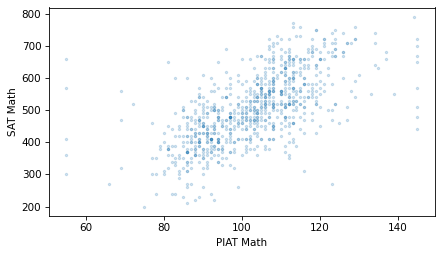

In [26]:
from thinkstats import scatter

scatter(nlsy, "piat_math", "sat_math")

decorate(xlabel="PIAT Math", ylabel="SAT Math")

As expected, students who do well on the PIAT are likely to do well on the SAT math.
And if math and verbal ability are related, we expect them do well on the SAT verbal section, too.
The following figure shows the relationship between the PIAT and SAT verbal scores.

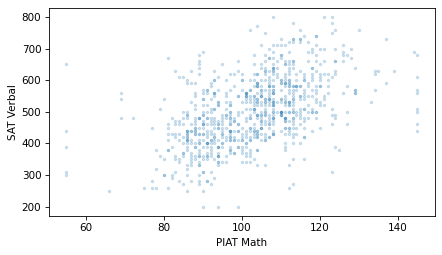

In [27]:
scatter(nlsy, "piat_math", "sat_verbal")

decorate(xlabel="PIAT Math", ylabel="SAT Verbal")

Students with higher PIAT scores also have higher SAT verbal scores, on average.

Comparing the scatter plots, the points in the first figure might be more compact, and the points in the second figure more dispersed.
If so, that means that the PIAT math scores predict SAT math scores more accurately than they predict SAT verbal scores -- and it makes sense if they do.

To quantify the strength of these relationships, we can use the **Pearson correlation coefficient**, often just called "correlation".
To understand correlation, let's start with standardization.

To standardize a variable, we subtract off the mean and divide through by the standard deviation, as in this function.

In [28]:
def standardize(xs):
    """Standardizes a sequence of numbers.

    xs: sequence of numbers

    returns: NumPy array
    """
    return (xs - np.mean(xs)) / np.std(xs)

To show how it's used, we'll select the rows where `piat_math` and `sat_math` are valid.

In [29]:
valid = nlsy.dropna(subset=["piat_math", "sat_math"])
piat_math = valid["piat_math"]
sat_math = valid["sat_math"]

And standardize the PIAT math scores.

In [30]:
piat_math_standard = standardize(piat_math)
np.mean(piat_math_standard), np.std(piat_math_standard)

(-2.4321756236287047e-16, 1.0)

The results are **standard scores**, also called "z-scores".
Because of the way the standard scores are calculated, the mean is close to 0 and the standard deviation is close to 1.

Let's also standardize the SAT math scores.

In [31]:
sat_math_standard = standardize(sat_math)
np.mean(sat_math_standard), np.std(sat_math_standard)

(-1.737268302591932e-16, 0.9999999999999998)

The following figure shows sequences of these scores for the first 100 participants.

Calling `subplot` with the arguments `2, 1, 1` tells Matplotlib to create multiple plots, arranged in two rows and one column, and initializes the first plot.
Calling it again with the arguments `2, 1, 2` initializes the second plot.
`axhline` draws a horizontal line that spans the width of the axes.

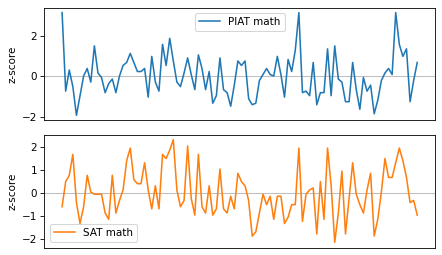

In [32]:
plt.subplot(2, 1, 1)
plt.axhline(0, color="gray", lw=1, alpha=0.5)
plt.plot(piat_math_standard.values[:100], label="PIAT math")
decorate(ylabel="z-score", xticks=[])

plt.subplot(2, 1, 2)
plt.axhline(0, color="gray", lw=1, alpha=0.5)
plt.plot(sat_math_standard.values[:100], label="SAT math", color="C1")
decorate(ylabel="z-score", xticks=[])

These variables are clearly related: when one is above the mean, the other is likely to be above the mean, too.
To quantify the strength of this relationship, we'll multiply the standard scores element-wise and compute the average of the products.

When both scores are positive, their product is positive, so it tends to increase the average product.
And when both scores are negative, their product is positive, so it also tends to increase the average product.
When the scores have opposite signs, the product is negative, so it decreases the average product.
As a result, the average product measures the similarity between the sequences.

In [33]:
np.mean(piat_math_standard * sat_math_standard)

0.639735816517885

The result, which is about 0.64, is the correlation coefficient.
Here's one way to interpret it: if someone's PIAT math score is 1 standard deviation above the mean, we expect their SAT math score to be 0.64 standard deviations above the mean, on average.

The result is the same if we multiply the elements in the other order.

In [34]:
np.mean(sat_math_standard * piat_math_standard)

0.639735816517885

So the correlation coefficient is symmetric: if someone's SAT math score is 1 standard deviation above the mean, we expect their PIAT math score to be 0.64 standard deviations above the mean, on average.

Correlation is a commonly-used statistic, so NumPy provides a function that computes it.

In [35]:
np.corrcoef(piat_math, sat_math)

array([[1.        , 0.63973582],
       [0.63973582, 1.        ]])

The result is a **correlation matrix**, with one row and one column for each variable.
The value in the upper left is the correlation of `piat_math` with itself.
The value in the lower right is the correlation of `sat_math` with itself.
The correlation of any variable with itself is 1, which indicates perfect correlation.

The values in the upper right and lower left are the correlation of `piat_math` with `sat_math` and the correlation of `sat_math` with `piat_math`, which are necessarily equal.

`thinkstats` provides a `corrcoef` function that takes a `DataFrame` and two column names, selects the rows where both columns are valid, and computes their correlation.

In [36]:
from thinkstats import corrcoef

corrcoef(nlsy, "piat_math", "sat_math")

0.6397358165178854

We can use this function to compute the correlation of `piat_math` and `sat_verbal`.

In [37]:
corrcoef(nlsy, "piat_math", "sat_verbal")

0.5094139146967309

The correlation is about 0.51, so if someone's PIAT math score is one standard deviation above the mean, we expect their SAT verbal score to be 0.51 standard deviations above the mean, on average.

As we might expect, PIAT math scores predict SAT math scores better than they predict SAT verbal scores.

## Strength of Correlation

As you look at more scatter plots, you will get a sense of what different correlations look like.
To help you develop this sense, the following figure shows scatter plots for randomly-generated data with the different correlations.

In [38]:
np.random.seed(17)
xs = np.random.normal(size=300)
ys = np.random.normal(size=300)

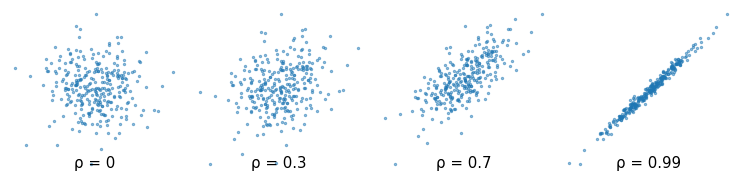

In [39]:
from thinkstats import make_correlated_scatter

plt.figure(figsize=(10, 2.5))

for i, rho in enumerate([0, 0.3, 0.7, 0.99]):
    plt.subplot(1, 4, i + 1)
    make_correlated_scatter(xs, ys, rho)
decorate()

The Greek letter ρ, which is spelled "rho" and pronounced like "row", is the conventional symbol for the correlation coefficient.

Correlation can also be negative.
Here are scatter plots for random data with a range of negative correlations.

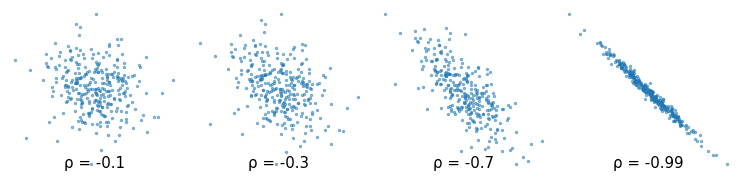

In [40]:
plt.figure(figsize=(10, 2.5))

for i, rho in enumerate([-0.1, -0.3, -0.7, -0.99]):
    plt.subplot(1, 4, i + 1)
    make_correlated_scatter(xs, ys, rho)
decorate()

The correlation coefficient is always between -1 and 1.
If there is no relationship between two variables, their correlation is 0 -- but if the correlation is 0, that doesn't necessarily mean there is no relationship.

In particular, if there is a non-linear relationship, the correlation coefficient can be close to 0.
In each of the following examples, there is a clear relationship between the variables in the sense that if we are given one of the values, we can make a substantially better prediction of the other.
But in each case the correlation coefficient is close to 0.

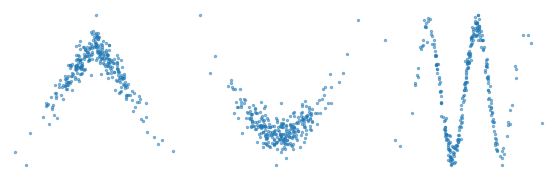

In [41]:
from thinkstats import make_nonlinear_scatter

plt.figure(figsize=(10, 2.5))

for i, kind in enumerate(["abs", "quadratic", "sinusoid"]):
    plt.subplot(1, 4, i + 1)
    make_nonlinear_scatter(xs, ys, kind)
decorate()

Correlation quantifies the strength of a *linear* relationship between variables.
If there is a non-linear relationship, the correlation coefficient can be misleading.
And if the correlation is close to 0, that does *not* mean there is no relationship.

## Rank Correlation


The NLSY is longitudinal, which means that it follows the same group of people over time.
The group we've been studying includes people born between 1980 and 1984.
The ones who took the SAT probably took it in the late 1990s, when they were about 18 years old.
So when they were asked about their income in 2021, they were in their late 30s or early 40s.
Let's give the column with the income data a more interpretable name.

In [42]:
nlsy["income"] = nlsy["U4949700"]
nlsy["income"].describe()

count      6051.000000
mean     104274.239960
std      108470.571497
min           0.000000
25%       38000.000000
50%       80000.000000
75%      134157.000000
max      599728.000000
Name: income, dtype: float64

The values in this column are gross family income, which is total income of the respondent and the other members of their household, from all sources, reported in U.S. dollars (USD).
Here's what the distribution of income looks like.

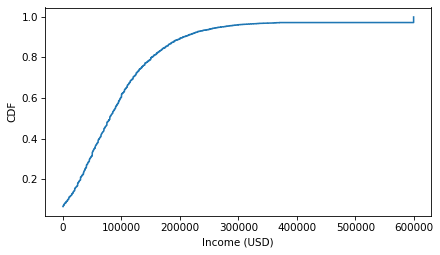

In [43]:
cdf_income = Cdf.from_seq(nlsy["income"])
cdf_income.step()

decorate(xlabel="Income (USD)", ylabel="CDF")

Notice the step near $600,000 -- values above this threshold were capped to protect the anonymity of the participants.
Now here's a scatter plot of the respondents' SAT math scores and their income later in life.

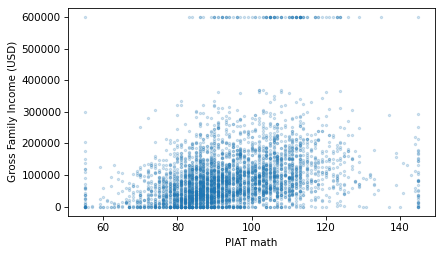

In [44]:
scatter(nlsy, "piat_math", "income")

decorate(xlabel="PIAT math", ylabel="Gross Family Income (USD)")

It looks like there is a relationship between these variables.
Here is the correlation.

In [45]:
corrcoef(nlsy, "piat_math", "income")

0.3033858728864124

The correlation is about 0.3, which means that if someone gets a PIAT math score one standard deviation above the mean when they are 15 years old, we expect their income to be about 0.3 standard deviations above the mean when they are 40.
That's not as strong as the correlation between PIAT scores and SAT scores, but considering the number of factors that affect income, it's pretty strong.

In fact, Pearson's correlation coefficient might understate the strength of the relationship.
As we can see in the previous scatter plot, both variables have an apparent excess of values at the extremes.
Because the correlation coefficient is based on the product of deviations from the mean, it is sensitive to these extreme values.

A more robust alternative is the **rank correlation**, which is based on the ranks of the scores rather than standardized scores.
We can use the Pandas method `rank` to compute the rank of each score and each income.

In [46]:
valid = nlsy.dropna(subset=["piat_math", "income"])

piat_math_rank = valid["piat_math"].rank(method="first")
income_rank = valid["income"].rank(method="first")

With the `method="first"` argument, `rank` assigns ranks from 1 to the length of the sequence, which is 4101.

In [47]:
income_rank.min(), income_rank.max()

(1.0, 4101.0)

Here's a scatter plot of income ranks versus math score ranks.

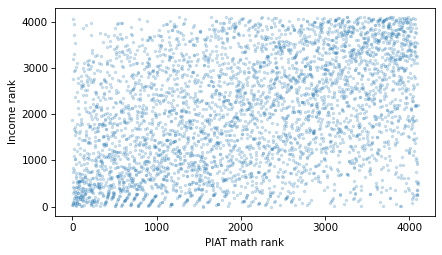

In [48]:
plt.scatter(piat_math_rank, income_rank, s=5, alpha=0.2)

decorate(xlabel="PIAT math rank", ylabel="Income rank")

And here's the correlation of the ranks.

In [49]:
np.corrcoef(piat_math_rank, income_rank)[0, 1]

0.38148396696764847

The result is about 0.38, somewhat higher than the Pearson correlation, which is 0.30.
Because rank correlation is less sensitive to the effect of extreme values, it is probably a better measure of the strength of the relationship between these variables.

`thinkplot` provides a `rankcorr` function that encapsulates the code in this section.

In [50]:
from thinkstats import rankcorr

rankcorr(nlsy, "piat_math", "income")

0.38474681505344815

And SciPy provides a similar function called `spearmanr`, because rank correlation is also called Spearman's correlation.

In [51]:
from scipy.stats import spearmanr

spearmanr(valid["piat_math"], valid["income"]).statistic

0.38474681505344815

As an exercise, you'll have a chance to compute the correlation between SAT verbal scores and income, using both Pearson correlation and rank correlation.

## Correlation and Causation

If variables A and B are correlated, the apparent correlation might be due to random sampling, or it might be the result of non-representative sampling, or it might indicate a real correlation between quantities in the population.

If the correlation is real, there are three possible explanations: A causes B, or B causes A, or some other set of factors causes both A and B. These explanations are called "causal relationships".

Correlation alone does not distinguish between these explanations, so it does not tell you which ones are true.
This rule is often summarized with the phrase "Correlation does not imply causation," which is so pithy it has its own Wikipedia page.

<http://wikipedia.org/wiki/Correlation_does_not_imply_causation>

So what can you do to provide evidence of causation?

1.  Use time. If A comes before B, then A can cause B but not the other way around.
The order of events can help us infer the direction of causation, but it does not preclude the possibility that something else causes both A and B.

2.  Use randomness.
If you divide a large sample into two groups at random and compute the means of almost any variable, you expect the difference to be small.
If the groups are nearly identical in all variables but A and B, you can rule out the possibility that something else causes both A and B.

These ideas are the motivation for the **randomized controlled trial**, in which subjects are assigned randomly to two (or more) groups: a **treatment group** that receives some kind of intervention, like a new medicine, and a **control group** that receives no intervention, or another treatment whose effects are known.
A randomized controlled trial is the most reliable way to demonstrate a causal relationship, and the foundation of evidence-based medicine.

Unfortunately, controlled trials are sometimes impossible or unethical.
An alternative is to look for a **natural experiment**, where similar groups are exposed to different conditions due to circumstances beyond the control of the experimenter.

Identifying and measuring causal relationships is the topic of a branch of statistics called **causal inference**.

- 시간의 사용 (Use time):
만약 A가 B보다 시간적으로 먼저 발생한다면, A가 B의 원인일 가능성이 있습니다. \
하지만 이 역시 제3의 요인을 배제할 수는 없습니다.

- 무작위성 사용 (Use randomness):
무작위 배정 대조군 연구(Randomized controlled trial)를 통해 인과관계를 가장 확실하게 증명할 수 있습니다. \
이 방법은 대규모의 집단을 무작위로 두 그룹(치료 그룹과 대조 그룹)으로 나누어 한 그룹에만 특정 처치를 가한 후 결과를 비교합니다. \
무작위 배정을 통해 두 그룹의 다른 모든 요인들이 비슷하다고 가정할 수 있어, 처치가 결과의 원인임을 증명할 수 있습니다.

## Glossary

-   **scatter plot**: A visualization that shows the relationship between two variables by plotting one point for each observation in the dataset.

-   **overplotted:** A scatter plot is overplotted if many markers overlap, making it hard to distinguish areas of different density, which can misrepresent the relationship.

-   **jitter**: Random noise added to data points in a plot to make overlapping values more visible.

-   **decile plot:** A plot that divides data into deciles (ten groups) based on one variable, then summarizes another variable for each group.

-   **decile:** One of the groups created by sorting data and dividing it into ten roughly equal parts.

- **Pearson correlation coefficient:** A statistic that measures the strength and sign (positive or negative) of the linear relationship between two variables.

-   **standard score**: A quantity that has been standardized so that it is expressed in standard deviations from the mean.

-   **correlation matrix:** A table showing the correlation coefficients for each pair of variables in a dataset.

-   **rank correlation**: A robust way to quantify the strength of a relationship by using the ranks of values instead of the actual values.

-   **randomized controlled trial**: An experiment where subjects are randomly assigned to groups that receive different treatments.

-   **treatment group**: In an experiment, the group that receives the intervention being tested.

-   **control group**: In an experiment, the group that does not receive the intervention, or receives a treatment whose effect is known.

-   **natural experiment**: An experiment that uses naturally occurring groups, which can sometimes mimic random assignment.

-   **causal inference:** Methods for identifying and quantifying cause-and-effect relationships.


## Exercises

### Exercise 7.1

The `thinkstats` module provides a function called `decile_plot` that encapsulates the code from earlier in this chapter.
We can call it like this to visualize the relationship between SAT verbal and math scores.

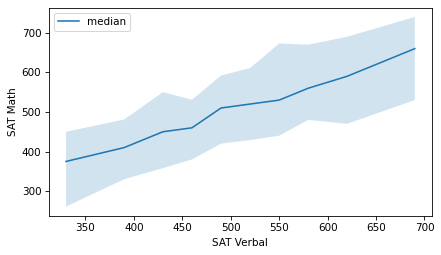

In [52]:
from thinkstats import decile_plot

decile_plot(nlsy, "sat_verbal", "sat_math")
decorate(xlabel="SAT Verbal", ylabel="SAT Math")

Make a decile plot of PIAT math scores and income.
Does it appear to be a linear relationship?

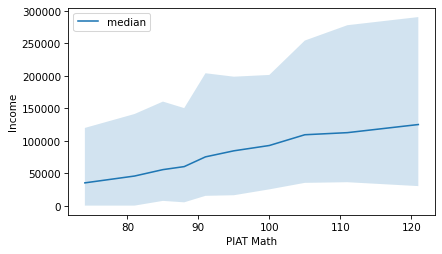

In [53]:
# Solution goes here
decile_plot(nlsy, "piat_math", "income")
decorate(xlabel="PIAT Math", ylabel="Income")

- 약한 선형관계?

### Exercise 7.2

Make a scatter plot of income versus SAT math scores.
Compute Pearson's correlation and rank correlation.
Are they substantially different?

Make a scatter plot of income versus SAT verbal scores, and compute both correlations.
Which is a stronger prediction of future income, math or verbal scores?

--- Income vs SAT Math 점수 분석 결과 ---
피어슨 상관계수: 0.2994
순위 상관계수: 0.3023




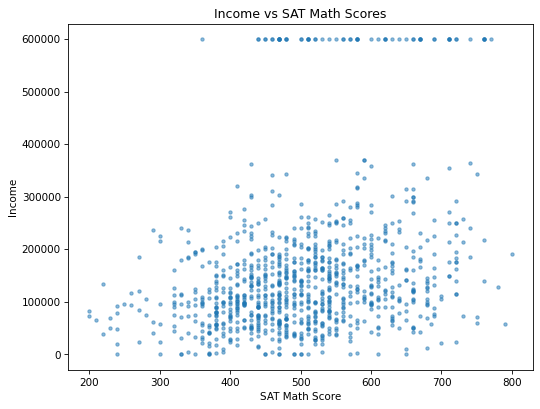

In [56]:
# Solution goes here
# 소득 vs. SAT Math 점수 분석
valid_data_math = nlsy.dropna(subset=['income', 'sat_math'])
income_math = valid_data_math['income']
sat_math = valid_data_math['sat_math']

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(sat_math, income_math, alpha=0.5, s=10)
plt.title('Income vs SAT Math Scores')
plt.xlabel('SAT Math Score')
plt.ylabel('Income')

# 피어슨 상관계수
pearson_corr_math = np.corrcoef(sat_math, income_math)[0, 1]

# Rank correlation
sat_math_rank = sat_math.rank(method="first")
income_math_rank = income_math.rank(method="first")
rank_corr_math = np.corrcoef(sat_math_rank, income_math_rank)[0, 1]

print("--- Income vs SAT Math 점수 분석 결과 ---")
print(f"피어슨 상관계수: {pearson_corr_math:.4f}")
print(f"순위 상관계수: {rank_corr_math:.4f}")
print("\n")

--- Income vs SAT Verbal 점수 분석 결과 ---
피어슨 상관계수: 0.1989
순위 상관계수: 0.2248




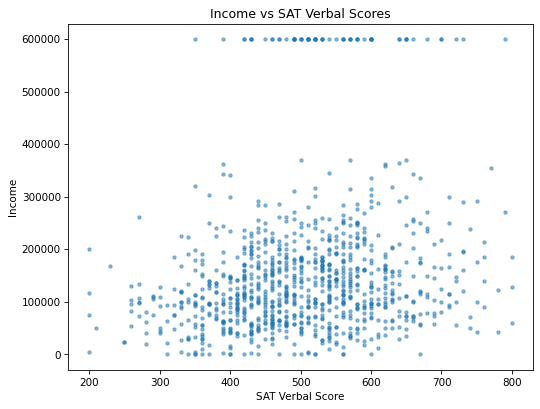

In [57]:
# Solution goes here
# 소득 vs. SAT Verbal 점수 분석
valid_data_verbal = nlsy.dropna(subset=['income', 'sat_verbal'])
income_verbal = valid_data_verbal['income']
sat_verbal = valid_data_verbal['sat_verbal']

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(sat_verbal, income_verbal, alpha=0.5, s=10)
plt.title('Income vs SAT Verbal Scores')
plt.xlabel('SAT Verbal Score')
plt.ylabel('Income')

# 피어슨 상관계수
pearson_corr_verbal = np.corrcoef(sat_verbal, income_verbal)[0, 1]

# Rank correlation
sat_verbal_rank = sat_verbal.rank(method="first")
income_verbal_rank = income_verbal.rank(method="first")
rank_corr_verbal = np.corrcoef(sat_verbal_rank, income_verbal_rank)[0, 1]

print("--- Income vs SAT Verbal 점수 분석 결과 ---")
print(f"피어슨 상관계수: {pearson_corr_verbal:.4f}")
print(f"순위 상관계수: {rank_corr_verbal:.4f}")
print("\n")

### Exercise 7.3

Let's see how a student's high school grade point average (GPA) is correlated with their SAT scores.
Here's the variable in the NLSY dataset that encodes GPA.

In [58]:
missing_codes = [-6, -7, -8, -9]
nlsy["gpa"] = nlsy["R9871900"].replace(missing_codes, np.nan) / 100
nlsy["gpa"].describe()

count    6004.000000
mean        2.818408
std         0.616357
min         0.100000
25%         2.430000
50%         2.860000
75%         3.260000
max         4.170000
Name: gpa, dtype: float64

And here's what the distribution of GPAs looks like.

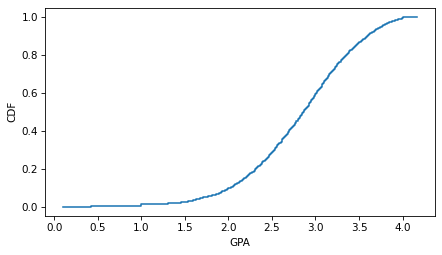

In [59]:
cdf_income = Cdf.from_seq(nlsy["gpa"])
cdf_income.step()
decorate(xlabel="GPA", ylabel="CDF")

Make a scatter plot that shows the relationship between GPA and SAT math scores and compute the correlation coefficient.
Do the same for the relationship between GPA and SAT verbal scores.
Which SAT score is a better predictor of GPA?

--- GPA vs SAT Math 분석 결과 ---
상관계수: 0.4866




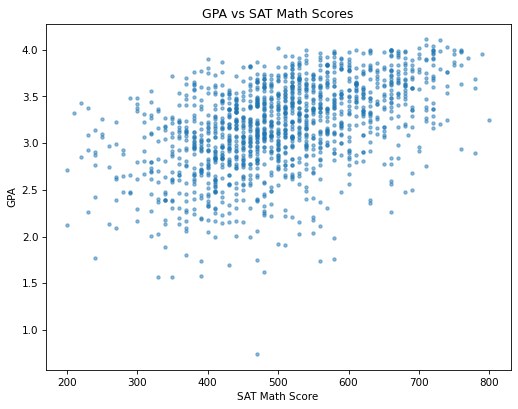

In [ ]:
# Solution goes here
# GPA와 SAT Math 점수 간의 관계 분석
valid_gpa_math = nlsy.dropna(subset=['gpa', 'sat_math'])
gpa_math = valid_gpa_math['gpa']
sat_math = valid_gpa_math['sat_math']

# 산점도
plt.figure(figsize=(8, 6))
plt.scatter(sat_math, gpa_math, alpha=0.5, s=10)
plt.title('GPA vs SAT Math Scores')
plt.xlabel('SAT Math Score')
plt.ylabel('GPA')

# 상관계수
corr_gpa_math = np.corrcoef(gpa_math, sat_math)[0, 1]
print("--- GPA vs SAT Math 분석 결과 ---")
print(f"상관계수: {corr_gpa_math:.4f}")

--- GPA vs SAT Verbal 분석 결과 ---
상관계수: 0.4284


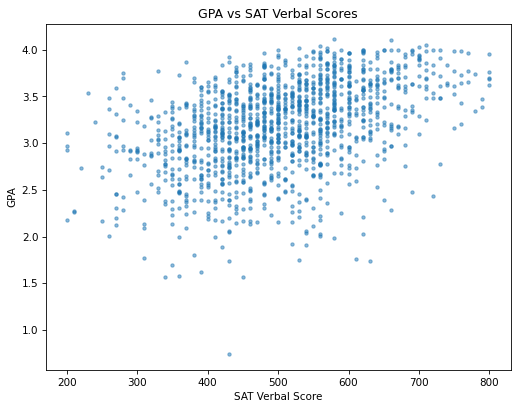

In [62]:
# Solution goes here
# GPA와 SAT Verbal 점수 간의 관계 분석
valid_gpa_verbal = nlsy.dropna(subset=['gpa', 'sat_verbal'])
gpa_verbal = valid_gpa_verbal['gpa']
sat_verbal = valid_gpa_verbal['sat_verbal']

# 산점도
plt.figure(figsize=(8, 6))
plt.scatter(sat_verbal, gpa_verbal, alpha=0.5, s=10)
plt.title('GPA vs SAT Verbal Scores')
plt.xlabel('SAT Verbal Score')
plt.ylabel('GPA')

# 상관계수
corr_gpa_verbal = np.corrcoef(gpa_verbal, sat_verbal)[0, 1]
print("--- GPA vs SAT Verbal 분석 결과 ---")
print(f"상관계수: {corr_gpa_verbal:.4f}")

### Exercise 7.4

Let's investigate the relationship between education and income.
The NLSY dataset includes a column that reports the highest degree earned by each respondent.
The values are encoded as integers.

In [63]:
nlsy["degree"] = nlsy["Z9083900"]
nlsy["degree"].value_counts().sort_index()

degree
0.0     877
1.0    1167
2.0    3531
3.0     766
4.0    1713
5.0     704
6.0      64
7.0     130
Name: count, dtype: int64

But we can use these lists to decode them.

In [64]:
positions = [0, 1, 2, 3, 4, 5, 6, 7]
labels = [
    "None",
    "GED",
    "High school diploma",
    "Associate's degree",
    "Bachelor's degree",
    "Master's degree",
    "PhD",
    "Professional degree",
]

And make a `Pmf` that represents the distribution of educational attainment.

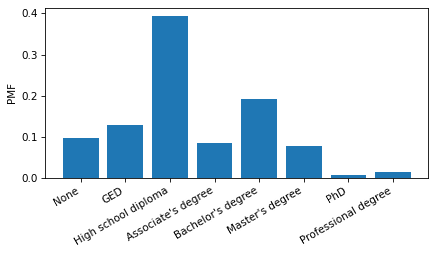

In [65]:
from empiricaldist import Pmf

Pmf.from_seq(nlsy["degree"]).bar()

plt.xticks(positions, labels, rotation=30, ha="right")
decorate(ylabel="PMF")

Make a scatter plot of `income` versus `degree`.
To avoid overplotting, jitter the values of `degree` and adjust the marker size and transparency.

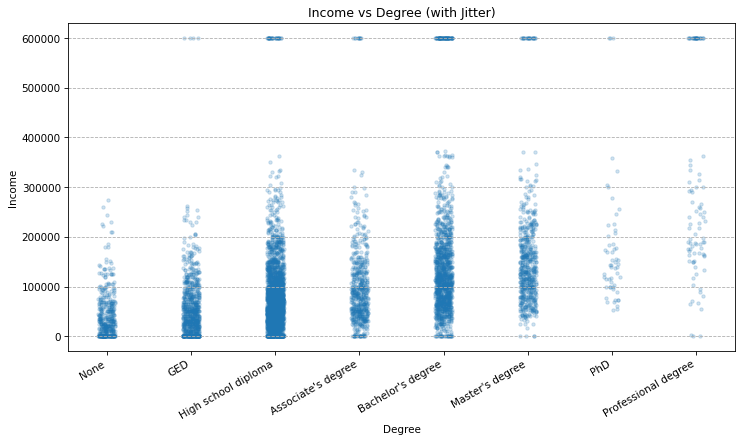

In [66]:
# Solution goes here
# income vs. degree 산점도
plt.figure(figsize=(10, 6))

jitter = np.random.uniform(-0.1, 0.1, size=len(nlsy))
plt.scatter(nlsy['degree'] + jitter, nlsy['income'], s=10, alpha=0.2)

plt.title('Income vs Degree (with Jitter)')
plt.xlabel('Degree')
plt.ylabel('Income')
plt.xticks(positions, labels, rotation=30, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

Use the `groupby` method to group respondents by `degree`.
From the `DataFrameGroupBy` object, select the `income` column; then use the `quantile` method to compute the median, 10th and 90th percentiles in each group.
Use `fill_between` to plot the region between the 10th and 90th percentiles, and use `plot` to plot the medians.

What can you say about the income premium associated with each additional degree?

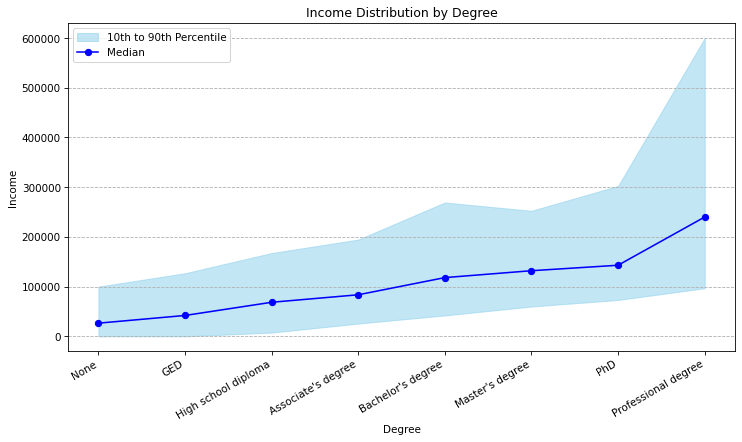

In [67]:
# Solution goes here
# 학위별 소득 분포
# 'degree' 컬럼으로 그룹화
grouped = nlsy.groupby('degree')['income']

medians = grouped.quantile(0.5)
p10 = grouped.quantile(0.1)
p90 = grouped.quantile(0.9)

plt.figure(figsize=(10, 6))

plt.fill_between(medians.index, p10, p90, color='skyblue', alpha=0.5, label='10th to 90th Percentile')

plt.plot(medians.index, medians, marker='o', linestyle='-', color='blue', label='Median')
plt.title('Income Distribution by Degree')
plt.xlabel('Degree')
plt.ylabel('Income')
plt.xticks(positions, labels, rotation=30, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

### Exercise 7.4

The Behavioral Risk Factor Surveillance System (BRFSS) dataset includes self-reported heights and weights for about 400,000 respondents.
Instructions for downloading the data are in the notebook for this chapter.

Make a scatter plot that shows the relationship between height and weight.
You might have to jitter the data to blur the visible rows and columns due to rounding.
And with such a large sample, you will have to adjust the marker size and transparency to avoid overplotting.
Also, because there are outliers in both measurements, you might want to use `xlim` and `ylim` to zoom in on a region that covers most of the respondents.

Here's how we can load the data.

In [68]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

In [69]:
from thinkstats import read_brfss

brfss = read_brfss()
brfss["htm3"].describe()

count    409129.000000
mean        168.825190
std          10.352653
min          61.000000
25%         160.000000
50%         168.000000
75%         175.000000
max         236.000000
Name: htm3, dtype: float64

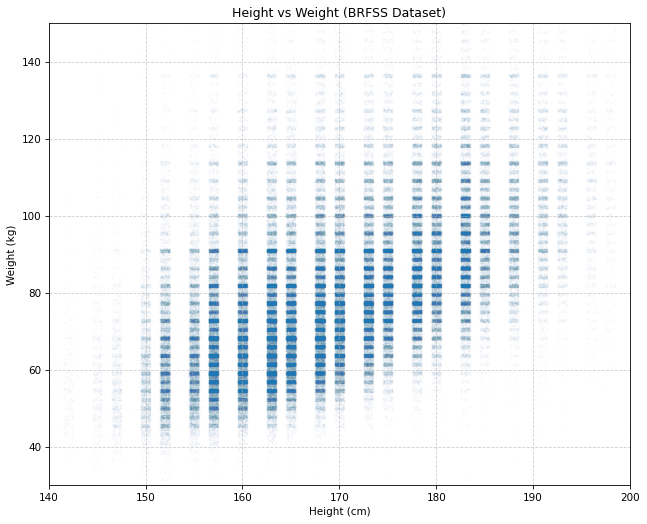

In [70]:
# Solution goes here
# 키(htm3)와 몸무게(wtkg2)의 관계를 보여주는 산점도
plt.figure(figsize=(10, 8))

jitter_x = np.random.uniform(-0.5, 0.5, size=len(brfss))
jitter_y = np.random.uniform(-0.5, 0.5, size=len(brfss))

plt.scatter(brfss['htm3'] + jitter_x, brfss['wtkg2'] + jitter_y, s=1, alpha=0.01)
plt.xlim(140, 200)
plt.ylim(30, 150)
plt.title('Height vs Weight (BRFSS Dataset)')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Make a decile plot of weight versus height. Does the relationship seem to be linear?
Compute the correlation coefficient and rank correlation. Are they substantially different? Which one do you think better quantifies the relationship between these variables?

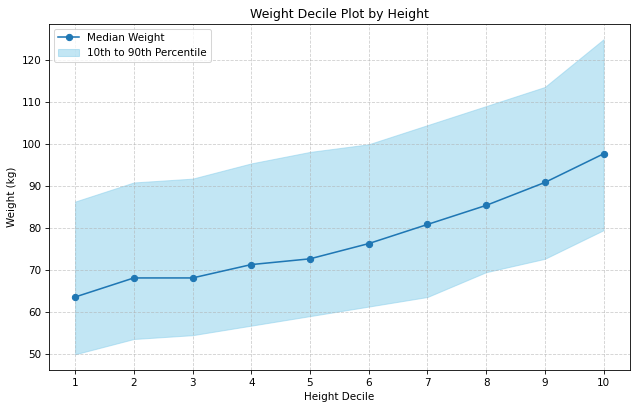

In [71]:
# Solution goes here
# height를 기준으로 decile
brfss['decile'] = pd.qcut(brfss['htm3'], q=10, labels=False) + 1

# 각 데실 그룹의 중앙 몸무게(median weight)를 계산
medians_by_decile = brfss.groupby('decile')['wtkg2'].median()
p10_by_decile = brfss.groupby('decile')['wtkg2'].quantile(0.1)
p90_by_decile = brfss.groupby('decile')['wtkg2'].quantile(0.9)

plt.figure(figsize=(10, 6))
plt.plot(medians_by_decile.index, medians_by_decile.values, marker='o', label='Median Weight')
plt.fill_between(medians_by_decile.index, p10_by_decile, p90_by_decile, color='skyblue', alpha=0.5, label='10th to 90th Percentile')
plt.title('Weight Decile Plot by Height')
plt.xlabel('Height Decile')
plt.ylabel('Weight (kg)')
plt.xticks(medians_by_decile.index)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Solution goes here
# 피어슨 상관계수
valid_data = brfss.dropna(subset=['htm3', 'wtkg2'])
pearson_corr = np.corrcoef(valid_data['htm3'], valid_data['wtkg2'])[0, 1]

# 순위 상관계수
height_rank = valid_data['htm3'].rank(method="first")
weight_rank = valid_data['wtkg2'].rank(method="first")
rank_corr = np.corrcoef(height_rank, weight_rank)[0, 1]

print("--- 상관관계 분석 ---")
print(f"피어슨 상관계수 (Pearson's r): {pearson_corr:.4f}")
print(f"순위 상관계수 (Rank Correlation): {rank_corr:.4f}")
print("\n")

--- 상관관계 분석 ---
피어슨 상관계수 (Pearson's r): 0.5087
순위 상관계수 (Rank Correlation): 0.5415




[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)